In [1]:
# DQN CartPole
# See Tutorial below
# https://medium.com/@ym1942/deep-q-learning-dqn-tutorial-with-cartpole-v0-5505dbd2409e


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from typing import List, Tuple

import collections
from collections import namedtuple, deque
import tqdm
import matplotlib.pyplot as plt
import random
import gymnasium as gym
import session_info

from IPython.display import clear_output
from IPython import display

%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
# Create CartPole environment
env = gym.make('CartPole-v1', render_mode='human')
state, _ = env.reset()

# Run the environment for 100 steps
for i in range(100):
    # Display the current state of the environment
    env.render()
    
    # Choose a random action from the action space
    action = env.action_space.sample()
    
    # Take the chosen action and observe the next state, reward, and termination status
    state, reward, terminated, truncated, info = env.step(action)
    if terminated:
        print('terminated', i)
    # If the episode is terminated or truncated, reset the environment
    if terminated or truncated:
        state, info = env.reset()

# Close the environment after exploration
env.close()



terminated 12
terminated 33
terminated 45
terminated 60
terminated 76
terminated 90


In [4]:
# Define the neural network model

# increasing the size of the network we get much better results at the expense of train time
# decreasing it you'll see much worse results (try 16 in second layer for instance)
# self.linear1 = nn.Linear(input_size, 16) hidden first layer 16
# self.linear2 = nn.Linear(16,64)          hidden second layer 64
# self.linear3 = nn.Linear(64,16)          hidden third layer 16

class FullyConnectedModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(FullyConnectedModel, self).__init__()

        # Define layers with ReLU activation
        self.linear1 = nn.Linear(input_size, 16)
        self.activation1 = nn.ReLU()
        self.linear2 = nn.Linear(16,64)
        self.activation2 = nn.ReLU()
        self.linear3 = nn.Linear(64, 16)
        self.activation3 = nn.ReLU()

        # Output layer without activation function
        self.output_layer = nn.Linear(16, output_size)

        # Initialization using Xavier uniform (a popular technique for initializing weights in NNs)
        nn.init.xavier_uniform_(self.linear1.weight)
        nn.init.xavier_uniform_(self.linear2.weight)
        nn.init.xavier_uniform_(self.linear3.weight)
        nn.init.xavier_uniform_(self.output_layer.weight)

    def forward(self, inputs):
        # Forward pass through the layers
        x = self.activation1(self.linear1(inputs))
        x = self.activation2(self.linear2(x))
        x = self.activation3(self.linear3(x))
        x = self.output_layer(x)
        return x

    
class QNetwork:
    def __init__(self, env, lr, logdir=None):
        # Define Q-network with specified architecture
        self.net = FullyConnectedModel(4, 2)
        self.env = env
        self.lr = lr 
        self.logdir = logdir
        self.optimizer = optim.Adam(self.net.parameters(), lr=self.lr)

    def load_model(self, model_file):
        # Load pre-trained model from a file
        return self.net.load_state_dict(torch.load(model_file))

    def load_model_weights(self, weight_file):
        # Load pre-trained model weights from a file
        return self.net.load_state_dict(torch.load(weight_file))


In [5]:
class ReplayMemory:
    def __init__(self, env, memory_size=50000, burn_in=20000):
        # Initializes the replay memory, which stores transitions recorded from the agent taking actions in the environment.
        self.memory_size = memory_size
        self.burn_in = burn_in
        self.memory = collections.deque([], maxlen=memory_size)
        self.env = env

    def sample_batch(self, batch_size=32):
        # Returns a batch of randomly sampled transitions to be used for training the model.
        return random.sample(self.memory, batch_size)

    def append(self, transition):
        # Appends a transition to the replay memory.
        self.memory.append(transition)


In [6]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class DQN_Agent:

    def __init__(self, environment_name, lr=5e-4, render=False):
        # Initialize the DQN Agent.
        self.env = gym.make(environment_name)
        self.lr = lr
        self.policy_net = QNetwork(self.env, self.lr)
        self.target_net = QNetwork(self.env, self.lr)
        self.target_net.net.load_state_dict(self.policy_net.net.state_dict())  # Copy the weight of the policy network
        self.rm = ReplayMemory(self.env)
        self.burn_in_memory()
        self.batch_size = 16  # 32
        self.gamma = 0.99
        self.c = 0

    def burn_in_memory(self):
        # Initialize replay memory with a burn-in number of episodes/transitions.
        cnt = 0
        terminated = False
        truncated = False
        state, _ = self.env.reset()
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)

        # Iterate until we store "burn_in" buffer
        while cnt < self.rm.burn_in:
            # Reset environment if terminated or truncated
            if terminated or truncated:
                state, _ = self.env.reset()
                state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            
            # Randomly select an action (left or right) and take a step
            action = torch.tensor(random.sample([0, 1], 1)[0]).reshape(1, 1)
            next_state, reward, terminated, truncated, _ = self.env.step(action.item())
            reward = torch.tensor([reward])
            if terminated:
                next_state = None
            else:
                next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)
                
            # Store new experience into memory
            transition = Transition(state, action, next_state, reward)
            self.rm.memory.append(transition)
            state = next_state
            cnt += 1

    def epsilon_greedy_policy(self, q_values, epsilon=0.05):
        # Implement an epsilon-greedy policy. 
        p = random.random()
        if p > epsilon:
            with torch.no_grad():
                return self.greedy_policy(q_values)
        else:
            return torch.tensor([[self.env.action_space.sample()]], dtype=torch.long)

    def greedy_policy(self, q_values):
        # Implement a greedy policy for test time.
        return torch.argmax(q_values)
        
    def train(self):
        # Train the Q-network using Deep Q-learning.
        state, _ = self.env.reset()
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        terminated = False
        truncated = False

        # Loop until reaching the termination state
        while not (terminated or truncated):
            with torch.no_grad():
                q_values = self.policy_net.net(state)

            # Decide the next action with epsilon greedy strategy
            action = self.epsilon_greedy_policy(q_values).reshape(1, 1)
            
            # Take action and observe reward and next state
            next_state, reward, terminated, truncated, _ = self.env.step(action.item())
            reward = torch.tensor([reward])
            if terminated:
                next_state = None
            else:
                next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)

            # Store the new experience
            transition = Transition(state, action, next_state, reward)
            self.rm.memory.append(transition)

            # Move to the next state
            state = next_state

            # Sample minibatch with size N from memory
            transitions = self.rm.sample_batch(self.batch_size)
            batch = Transition(*zip(*transitions))
            non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), dtype=torch.bool)
            non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
            state_batch = torch.cat(batch.state)
            action_batch = torch.cat(batch.action)
            reward_batch = torch.cat(batch.reward)

            # Get current and next state values
            state_action_values = self.policy_net.net(state_batch).gather(1, action_batch) # extract values corresponding to the actions Q(S_t, A_t)
            next_state_values = torch.zeros(self.batch_size)
            
            with torch.no_grad():
                # no next_state_value update if an episode is terminated (next_satate = None)
                # only update the non-termination state values (Ref: https://gymnasium.farama.org/tutorials/gymnasium_basics/handling_time_limits/)
                next_state_values[non_final_mask] = self.target_net.net(non_final_next_states).max(1)[0] # extract max value
                
            # Update the model
            expected_state_action_values = (next_state_values * self.gamma) + reward_batch
            criterion = torch.nn.MSELoss()
            loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
            self.policy_net.optimizer.zero_grad()
            loss.backward()
            self.policy_net.optimizer.step()

            # Update the target Q-network in each 50 steps
            self.c += 1
            if self.c % 50 == 0:
                self.target_net.net.load_state_dict(self.policy_net.net.state_dict())

    def test(self, model_file=None):
        # Evaluates the performance of the agent over 20 episodes.

        max_t = 1000
        state, _ = self.env.reset()
        rewards = []

        for t in range(max_t):
            state = torch.from_numpy(state).float().unsqueeze(0)
            with torch.no_grad():
                q_values = self.policy_net.net(state)
            action = self.greedy_policy(q_values)
            state, reward, terminated, truncated, _ = self.env.step(action.item())
            rewards.append(reward)
            if terminated or truncated:
                break

        return np.sum(rewards)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [14:24<00:00, 172.90s/it]


Text(0, 0.5, 'Avg. Return')

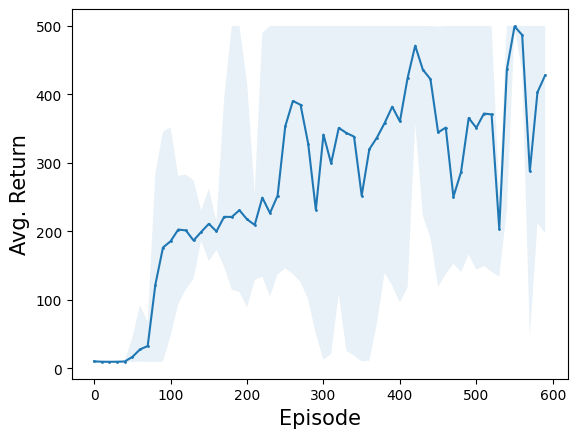

In [7]:
# Set environment and training parameters
env_name = 'CartPole-v1'
num_episodes_train = 600
num_episodes_test = 20
learning_rate = 5e-4

# Create the environment
env = gym.make(env_name)
action_space_size = env.action_space.n
state_space_size = 4

# Plot average performance of 5 trials
num_seeds = 5
l = num_episodes_train // 10
res = np.zeros((num_seeds, l))
gamma = 0.99

# Loop over multiple seeds
# remove comments for print verbose
for i in tqdm.tqdm(range(num_seeds)):
    reward_means = []

    # Create an instance of the DQN_Agent class
    agent = DQN_Agent(env_name, lr=learning_rate)

    # Training loop
    for m in range(num_episodes_train):
        agent.train()

        # Evaluate the agent every 10 episodes during training
        if m % 10 == 0:
#            print("Episode: {}".format(m))

            # Evaluate the agent's performance over 20 test episodes
            G = np.zeros(num_episodes_test)
            for k in range(num_episodes_test):
                g = agent.test()
                G[k] = g

            reward_mean = G.mean()
            reward_sd = G.std()
#            print(f"The test reward for episode {m} is {reward_mean} with a standard deviation of {reward_sd}.")
            reward_means.append(reward_mean)

    res[i] = np.array(reward_means)

# Plotting the average performance
ks = np.arange(l) * 10
avs = np.mean(res, axis=0)
maxs = np.max(res, axis=0)
mins = np.min(res, axis=0)

plt.fill_between(ks, mins, maxs, alpha=0.1)
plt.plot(ks, avs, '-o', markersize=1)

plt.xlabel('Episode', fontsize=15)
plt.ylabel('Avg. Return', fontsize=15)

In [8]:
#Create CartPole environment
env = gym.make('CartPole-v1', render_mode='human')
state, _ = env.reset()
k = 0
# Run the environment for 100 steps
for i in range(1000):
    # Display the current state of the environment
    env.render()
    
    # Choose an action based on the learned Q-network
    state = torch.from_numpy(state).float().unsqueeze(0)
    with torch.no_grad():
        q_values = agent.policy_net.net(state)
    action = agent.greedy_policy(q_values).detach().numpy()
    
    # Take the chosen action and observe the next state, reward, and termination status
    state, reward, terminated, truncated, _ = env.step(action)
    
    # If the episode is terminated or truncated, reset the environment
    if terminated or truncated:
        print('terminated',i-k)
        k = i
        state, info = env.reset()

# Close the environment after exploration
env.close()



terminated 499
terminated 500


In [9]:
session_info.show(html=False)

-----
gymnasium           0.29.1
matplotlib          3.9.1
numpy               1.26.4
session_info        1.0.0
torch               2.4.0+cu121
tqdm                4.66.4
-----
IPython             8.26.0
jupyter_client      8.6.2
jupyter_core        5.7.2
-----
Python 3.12.3 (main, Sep 11 2024, 14:17:37) [GCC 13.2.0]
Linux-5.15.153.1-microsoft-standard-WSL2-x86_64-with-glibc2.39
-----
Session information updated at 2024-09-19 12:59
